In [281]:
import pandas as pd
import os 
from pathlib import Path
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 200)

In [9]:
os.getcwd()

'/Users/macintosh/github/data-science-project'

In [72]:
INPUT_DIR = "/Users/Macintosh/Desktop/dataset/predict-energy-behavior-of-prosumers/"
# INPUT_DIR = Path("/Users/Macintosh/Downloads/predict-energy-behavior-of-prosumers/")
TEST_INPUT_DIR = "/Users/Macintosh/Desktop/dataset/predict-energy-behavior-of-prosumers/example_test_files/"


In [348]:
# Train Data
train_df = pd.read_csv(INPUT_DIR + "train.csv", sep= ",")
# train_df = pd.read_csv(INPUT_DIR / "train.csv", sep= ",")
client_df = pd.read_csv(INPUT_DIR + "client.csv", sep= ",")
electricity_prices_df = pd.read_csv(INPUT_DIR + "electricity_prices.csv", sep= ",")
forecast_weather_df = pd.read_csv(INPUT_DIR + "forecast_weather.csv", sep= ",")
gas_prices_df = pd.read_csv(INPUT_DIR + "gas_prices.csv", sep= ",")
historical_weather_df = pd.read_csv(INPUT_DIR + "historical_weather.csv", sep= ",")
weather_station_to_county_mapping_df = pd.read_csv(INPUT_DIR + "weather_station_to_county_mapping.csv", sep= ",")

In [77]:
# Test Data
test_df = pd.read_csv(TEST_INPUT_DIR + "test.csv")
sample_submission_df = pd.read_csv(TEST_INPUT_DIR + "sample_submission.csv")

In [44]:
train_df.shape

(2018352, 9)

In [45]:
pd.value_counts(train_df.dtypes)

int64      7
float64    1
object     1
Name: count, dtype: int64

In [46]:
train_df.select_dtypes(exclude='number').head()

,datetime
0,2021-09-01 00:00:00
1,2021-09-01 00:00:00
2,2021-09-01 00:00:00
3,2021-09-01 00:00:00
4,2021-09-01 00:00:00


In [48]:
train_df.describe(exclude='number')

,datetime
count,2018352
unique,15312
top,2022-11-27 12:00:00
freq,138


<AxesSubplot: title={'center': 'Unique Values per Feature'}>

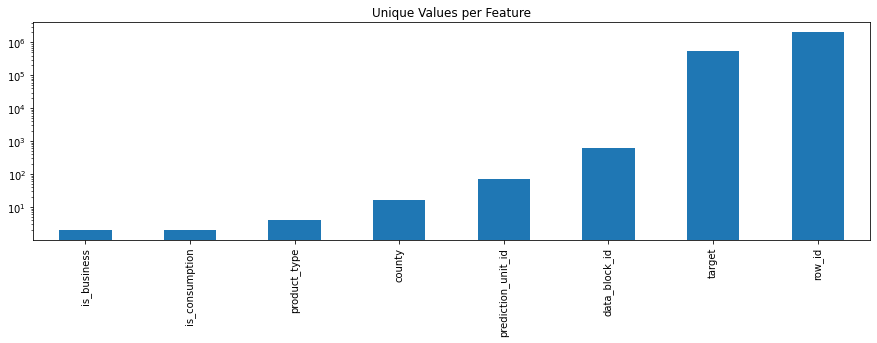

In [59]:
unique_values = train_df.select_dtypes(include='number').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15,4), title='Unique Values per Feature')

In [67]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [69]:
train_df.row_id.nunique()

2018352

In [87]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [88]:
train_df.drop(columns='county').head()

,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


<AxesSubplot: >

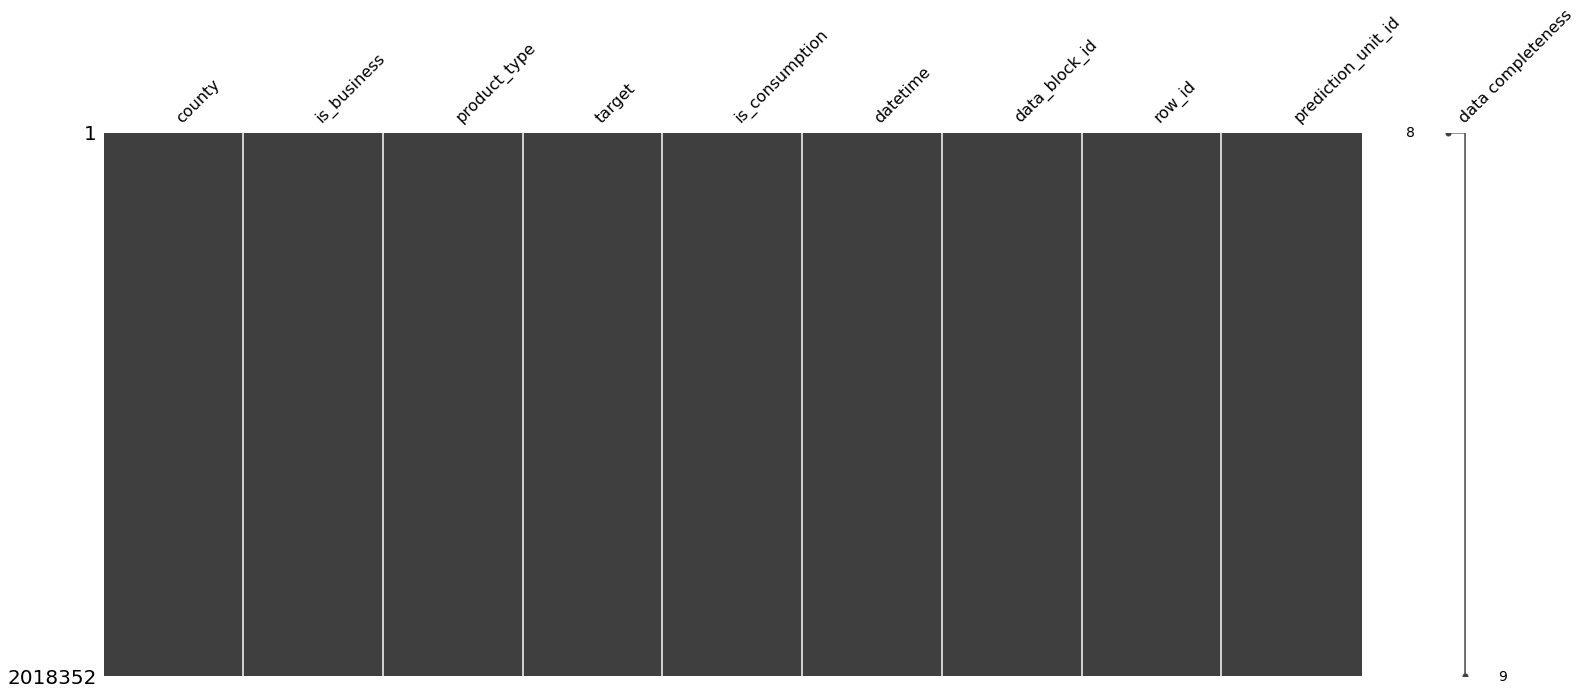

In [97]:
msno.matrix(train_df, labels=True, sort='ascending')

In [109]:
# Check each row and drop if missing value morethan 20% (how many columns missing each row?)
train_df = train_df.dropna(thresh=train_df.shape[1]*0.2, axis=0).reset_index(drop=True)
train_df.shape

(2018352, 9)

<AxesSubplot: title={'center': '% Missing Value per Feature'}, ylabel='Ratio'>

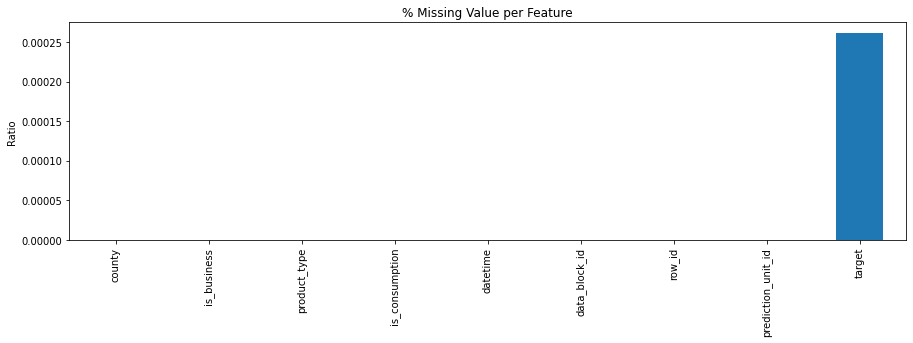

In [123]:
# Check per feature
train_df.isna().mean().sort_values()\
.plot(kind='bar', figsize=(15,4), title='% Missing Value per Feature',
ylabel='Ratio')

In [127]:
# Check each feature and drop if have morethan 15% of missing values
train_df = train_df.dropna(thresh=train_df.shape[0]*0.85, axis=1)
train_df.shape

(2018352, 9)

array([[<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >]], dtype=object)

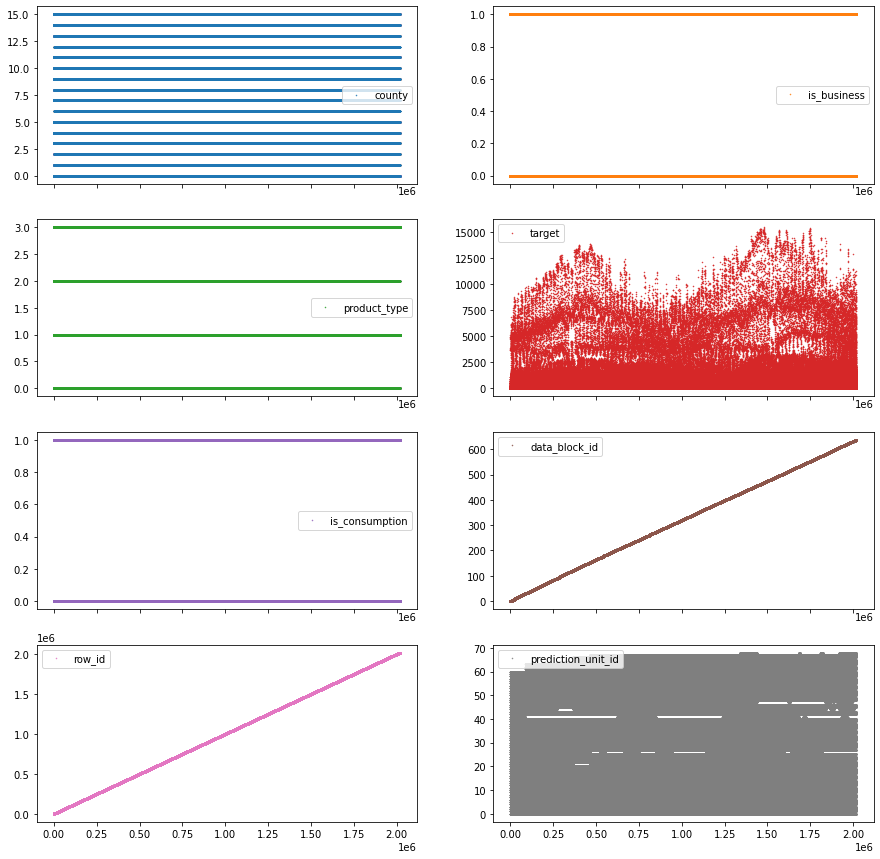

In [200]:
train_df.plot(lw=0, marker='.', subplots=True, layout=(-1,2), figsize=(15,15), markersize=1)

In [141]:
train_df.describe(exclude=['number', 'datetime'])

,datetime
count,2018352
unique,15312
top,2022-11-27 12:00:00
freq,138


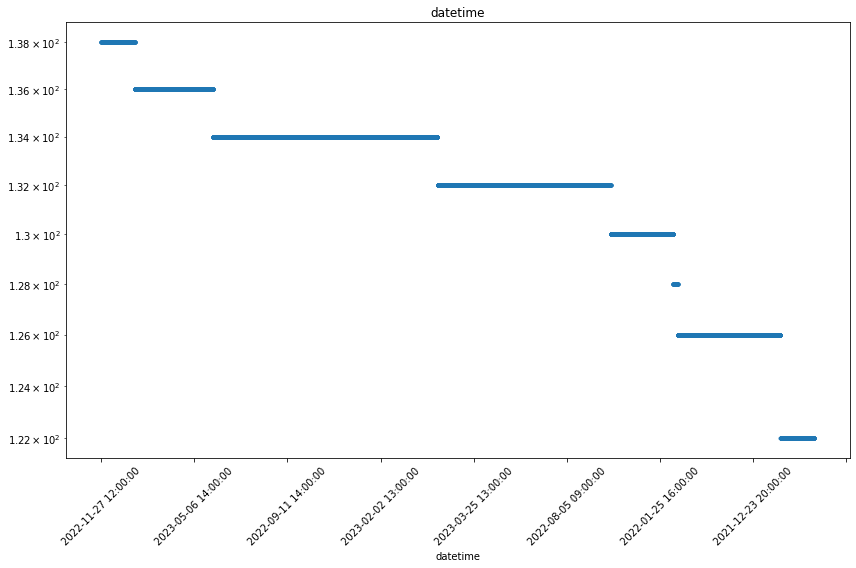

In [173]:
# Check unwanted non numerical features
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
df_non_numerical = train_df.select_dtypes(exclude=['number', 'datetime'])
for col in df_non_numerical.columns: # add zip(axes.ravel()) if we have more 1 subplots
    df_non_numerical[col].value_counts().plot(
        logy=True, title=col, lw=0, marker='.'
    )
plt.xticks(rotation=45)
plt.tight_layout()

In [188]:
# df_non_numerical.datetime.value_counts().head(10)

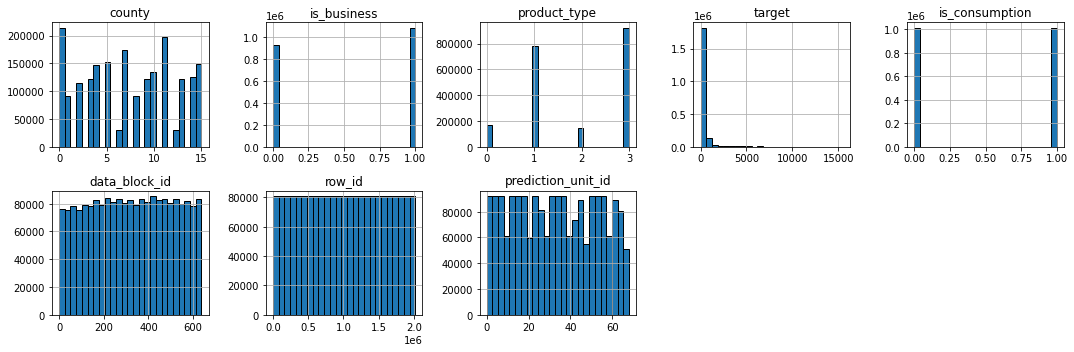

In [198]:
# Features distribution
train_df.hist(bins=25, figsize=(15,5), layout=(-1, 5), edgecolor='black')
plt.tight_layout()

In [257]:
# Find % of most frequent
most_frequent_entry = train_df.mode() # Check which data point is most frequent (mode) else NaN
df_freq = train_df.eq(most_frequent_entry.values, axis=1) # Check equal to make True or False
df_freq = df_freq.mean().sort_values(ascending = False) # Find Avg to check how many ratio that contain mode data.

In [260]:
display(df_freq.head(20))

row_id                1.000000e+00
is_consumption        9.909074e-07
county                4.954537e-07
prediction_unit_id    4.954537e-07
is_business           0.000000e+00
product_type          0.000000e+00
target                0.000000e+00
datetime              0.000000e+00
data_block_id         0.000000e+00
dtype: float64

<AxesSubplot: >

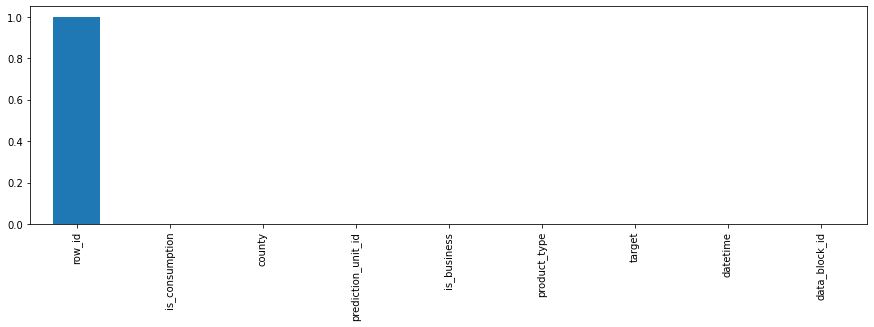

In [259]:
# row_id is unique that why got 100%
df_freq.plot.bar(figsize=(15,4))

In [207]:
most_frequent_entry.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0.0,1.0,3.0,0.0,0.0,2022-11-01 00:00:00,426.0,0,0.0
1,NaN,NaN,NaN,NaN,1.0,2022-11-01 01:00:00,427.0,1,1.0
2,NaN,NaN,NaN,NaN,NaN,2022-11-01 02:00:00,428.0,2,2.0
3,NaN,NaN,NaN,NaN,NaN,2022-11-01 03:00:00,429.0,3,3.0
4,NaN,NaN,NaN,NaN,NaN,2022-11-01 04:00:00,430.0,4,4.0


In [209]:
df_freq.head()

row_id                1.000000e+00
is_consumption        9.909074e-07
county                4.954537e-07
prediction_unit_id    4.954537e-07
is_business           0.000000e+00
dtype: float64

In [264]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [265]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression

In [381]:
# Create data frame for predict value
ALL_IDS = clean_df.row_id.unique()
oof = pd.DataFrame(data=np.zeros((len(ALL_IDS), 1)), index=ALL_IDS, columns=['target'])

In [291]:
oof.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [313]:
FEATURES = [i for i in train_df.select_dtypes(include='number').columns if i != 'target']

In [314]:
FEATURES

['county',
 'is_business',
 'product_type',
 'is_consumption',
 'data_block_id',
 'row_id',
 'prediction_unit_id']

In [315]:
model = {}

In [370]:
clean_df = train_df[~train_df['target'].isna()].reset_index(drop=True)

In [371]:
clean_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [378]:
def predict_feature(model_dict, model_name, data, output_data, features):
    gkf = GroupKFold(n_splits=5)
    for i, (train_idx, valid_idx) in enumerate(gkf.split(X=data, groups=data.index)):
        print(f'Fold {i+1}')
        print('=======')
        train_x = data.loc[train_idx]
        train_y = data.loc[train_idx]
        valid = data.loc[valid_idx]
        valid_ids = valid.row_id.values

        reg = LinearRegression()
        reg.fit(train_x[features], train_y['target'])

        model_dict[f'{model_name}'] = reg 
        output_data.loc[valid_ids] = reg.predict(valid[features])
    
    return output_data

In [379]:
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [383]:
oof.shape

(2017824, 1)

In [382]:
oof = predict_feature(model, 'first', clean_df, oof, ['county'])

Fold 1


ValueError: shape mismatch: value array of shape (403565,) could not be broadcast to indexing result of shape (403565,1)

In [279]:
train_df.iloc[0]

county                                  0
is_business                             0
product_type                            1
target                              0.713
is_consumption                          0
datetime              2021-09-01 00:00:00
data_block_id                           0
row_id                                  0
prediction_unit_id                      0
Name: 0, dtype: object

In [384]:
model

{'first': LinearRegression()}